In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # Deep learning library
import matplotlib.pyplot as plt # Visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MRK_

In [ ]:
df = pd.read_csv('../input/stock-time-series-20050101-to-20171231/AAPL_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...,...
3014,2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
3015,2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
3016,2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL
3017,2017-12-28,171.00,171.85,170.48,171.08,16480187,AAPL


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle_buffer > 0:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train, val = train_test_split(df.iloc[:, 1:4], test_size=0.2, shuffle=False)
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)[:, 0]
val = scaler.transform(val)[:, 0]
train = windowed_dataset(train, window_size=64, batch_size=128, shuffle_buffer=1000)
val = windowed_dataset(val, window_size=64, batch_size=128, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(64,1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(8, activation=tf.keras.activations.swish),
    tf.keras.layers.Dense(1),
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["mae"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 29,585
Trainable params: 29,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train,
    epochs=100,
    validation_data=val,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=10, 
            restore_best_weights=True
        ), 
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=5
        )
    ]
)

Epoch 1/100
19/19 [==============================] - 5s 140ms/step - loss: 0.0145 - mae: 0.1330 - val_loss: 0.0483 - val_mae: 0.2769
Epoch 2/100
19/19 [==============================] - 2s 87ms/step - loss: 0.0046 - mae: 0.0760 - val_loss: 0.0073 - val_mae: 0.0907
Epoch 3/100
19/19 [==============================] - 2s 90ms/step - loss: 0.0017 - mae: 0.0430 - val_loss: 0.0058 - val_mae: 0.0921
Epoch 4/100
19/19 [==============================] - 2s 97ms/step - loss: 7.6160e-04 - mae: 0.0308 - val_loss: 0.0038 - val_mae: 0.0725
Epoch 5/100
19/19 [==============================] - 2s 92ms/step - loss: 4.2974e-04 - mae: 0.0217 - val_loss: 0.0027 - val_mae: 0.0573
Epoch 6/100
19/19 [==============================] - 2s 86ms/step - loss: 3.2285e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0467
Epoch 7/100
19/19 [==============================] - 2s 87ms/step - loss: 1.9429e-04 - mae: 0.0143 - val_loss: 0.0017 - val_mae: 0.0442
Epoch 8/100
19/19 [==============================] - 2s 84m

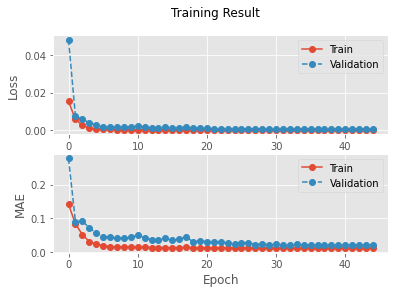

In [ ]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Training Result')
ax1.plot(history.history['loss'], 'o-', label='Train')
ax1.plot(history.history['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history.history['mae'], 'o-', label='Train')
ax2.plot(history.history['val_mae'], 'o--', label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
fig.show()